In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

import apertls
from matplotlib.colors import LogNorm

In [2]:
# This script takes around 8 minutes on a modern CPU (80s preparation+interpolation, 400s tracking)
beam = 1
plane = 'DNeg'#'DPpos'

num_particles  = 5000
sweep          = 3500
sweep          = -abs(sweep) if plane == 'DPpos' else abs(sweep)
#num_turns      = int(20*abs(sweep))
num_turns=6000

In [3]:
nemitt_x = 3.5e-6
nemitt_y = 3.5e-6

In [4]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

#setting all cavities to 200 (even 800 cavities) because rf sweep not implemented
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)
for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180

line['acl.31735'].voltage = 0


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
  #    cavities_200_all = [
    #     'actcse.31632', 'actcse.31637', 'actcse.31654', 
    #     'actcsf.31672', 'actcsf.31678', 'actcsf.31695', 
    #     'actcsg.31751', 'actcsg.31758', 'actcsg.31774', 'actcsg.31780', 
    #     'actcsh.31832', 'actcsh.31838', 'actcsh.31854', 
    #     'actcsi.31872', 'actcsi.31878', 'actcsi.31895', 
    #     'actcsj.31952', 'actcsj.31958', 'actcsj.31974', 'actcsj.31991'
    # ]
    # cavities_800_all = [
    #     'acl.31735', 'acl.31936'
    # ]

In [6]:
tw = line.twiss()

In [7]:
line.collimators.assign_optics()

In [8]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt_x,
                                          nemitt_y=nemitt_y,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004873
--> Emittance: 0.3420941521103455


In [9]:
part.to_json('test.json')

In [9]:
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='25'))

The line already has an associated tracker


In [10]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

The current frequency is 200000000.0Hz, adding 0.8333333333333334Hz per turn until 200005000.0 (for 6000 turns).
This sweep will move the center of the bucket with Δδ = -0.0139059583860353 (-1.9066513231874502 buckets).


In [11]:
line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()
print(f"Done sweeping RF in {line.time_last_track:.1f}s.")

No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.unique(part.at_element)

array([    0,  8400, 66905])

In [ ]:
line.element_names[8400]

'bpcn.12508.a_aper'

In [ ]:
line.element_names[66905]

'bpcn.61108.a_aper'

In [ ]:
line.get_s_position('bpcn.12508.a_aper')

np.float64(799.5902)

In [ ]:
line.get_s_position('bpcn.61108.a_aper')

np.float64(6111.2089000000005)

In [ ]:
#turn bins
turn_bins_resolution = 1000
turn_min, turn_max = 0, num_turns
turn_bins = np.linspace(turn_min, turn_max, turn_bins_resolution + 1)

#element bins
element_bin_resolution = 1000
element_min, element_max = 0, len(line.element_names)
element_bins = np.linspace(element_min, element_max, element_bin_resolution + 1)

hist2d, element_edges, turn_edges = np.histogram2d(
    part.at_element[part.state<=0], part.at_turn[part.state<=0],
    bins=[element_bins, turn_bins]
)

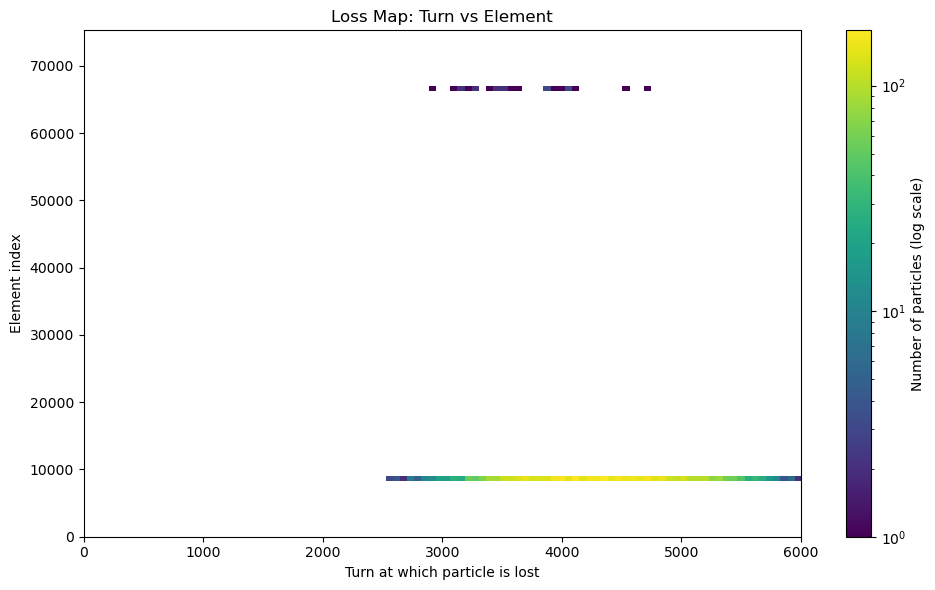

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(hist2d, aspect='auto', interpolation='nearest',
           extent=[turn_bins[0], turn_bins[-1], element_bins[0], element_bins[-1]],
           origin='lower', norm=LogNorm())

plt.colorbar(label='Number of particles (log scale)')
plt.xlabel('Turn at which particle is lost')
plt.ylabel('Element index')
plt.title('Loss Map: Turn vs Element')

plt.tight_layout()
plt.show()